In [25]:
from datasets import load_dataset

In [26]:
emotions = load_dataset("emotion")

In [27]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [28]:
train_ds = emotions['train']

In [29]:
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [30]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [31]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


## From Datasets to DataFrames

In [32]:
import pandas as pd

In [33]:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [34]:
def label_int2str(row):
    return emotions['train'].features['label'].int2str(row)


df['label_name'] = df['label'].apply(label_int2str)

df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [35]:
!pip3 install matplotlib

In [36]:
import matplotlib.pyplot as plt

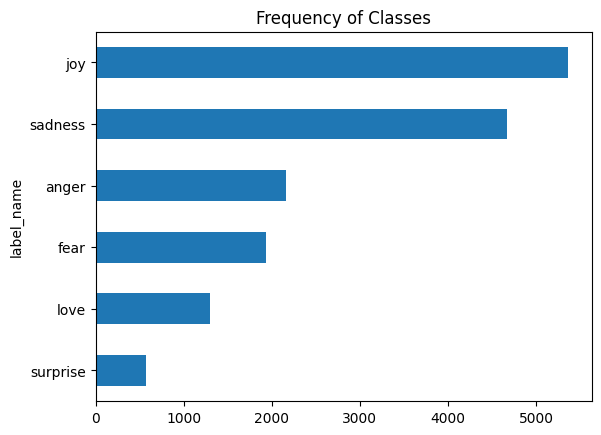

In [37]:
df['label_name'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

Here, we are going to keep the unbalanced class for simplicity. Will explore Imbalanced-learn library. In general, there are several ways to deal with the class imbalance problem:
- Randomly oversample the minority class
- Randomly undersample the majority class
- Gather more labeled data from the underrepresent class

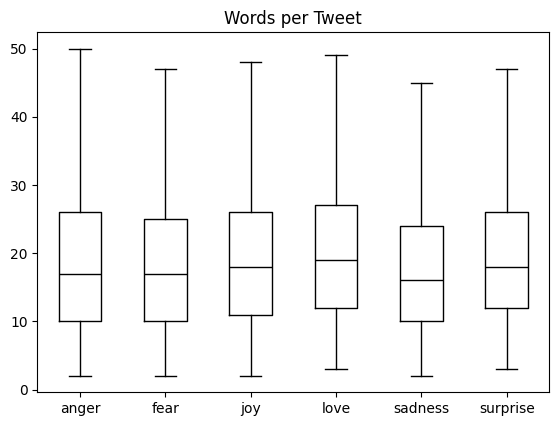

In [39]:
df['Words per Tweet'] = df['text'].str.split().apply(len)
df.boxplot("Words per Tweet", by="label_name", grid=False,
           showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

## Converting raw texts into format suitable for Transformers
Raw text -> tokens -> encoded as numerical values

In [40]:
emotions.reset_format()

In [43]:
!pip3 install transformers==4.49.0

  Obtaining dependency information for transformers==4.49.0 from https://files.pythonhosted.org/packages/20/37/1f29af63e9c30156a3ed6ebc2754077016577c094f31de7b2631e5d379eb/transformers-4.49.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 651.2 kB/s eta 0:00:00 kB/s eta 0:00:01
  Obtaining dependency information for regex!=2019.12.17 from https://files.pythonhosted.org/packages/c5/1b/f0e4d13e6adf866ce9b069e191f303a30ab1277e037037a365c3aad5cc9c/regex-2024.11.6-cp311-cp311-macosx_11_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 4.0 MB/s eta 0:00:00
  Obtaining dependency information for tokenizers<0.22,>=0.21 from https://files.pythonhosted.org/packages/ae/1a/4526797f3719b0287853f12c5ad563a9be09d446c44ac784cdd7c50f76ab/tokenizers-0.21.1-cp39-abi3-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for safetensors>=0.4.1 from https://files.pythonhosted.org/packages/b8/3b/11f1b4a2f5d2ab7da34ecc062b0bc301f2

## Subword tokenization
Best of both worlds (character and work tokenization):
- Split rare words into smaller units to allow model to deal with complex words and misspellings
- keep frequent words as unique entities so that we keep the length of our inputs to a manageable size

In [45]:
from transformers import AutoTokenizer

In [47]:
model_ckpt = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt) # Based on WordPiece


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [48]:
example_text = "Tokenizing text is a core task of NLP"

In [50]:
encoded_text = tokenizer(example_text)
print(encoded_text)

{'input_ids': [101, 1706, 6378, 4404, 3087, 1110, 170, 4160, 4579, 1104, 21239, 2101, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [51]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)

In [52]:
print(tokens)

['[CLS]', 'To', '##ken', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'NL', '##P', '[SEP]']


In [54]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] Tokenizing text is a core task of NLP [SEP]


In [57]:
tokenizer.vocab_size, tokenizer.model_max_length

(28996, 512)

In [58]:
def tokenize(batch, text_column_name="text"):
    return tokenizer(batch[text_column_name], padding=True, truncation=True)

In [59]:
print(tokenize(emotions['train'][:2]))

{'input_ids': [[101, 178, 1238, 1204, 1631, 21820, 21896, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 178, 1169, 1301, 1121, 2296, 1177, 24858, 1106, 1177, 10688, 19953, 1198, 1121, 1217, 1213, 1800, 1150, 16903, 1105, 1110, 8264, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [61]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]